# Intercompare Cell Size Distributions

## Libs Sections 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_context('talk')
import cartopy.crs as ccrs
import cartopy.feature as cf


import glob

import tobac
import sys
import json




## Input Data 

In [2]:
main_dir = "/work/bb1376/user/fabian/data/oxford-hackathon/icon-hamlite/*/statistics"

flist = sorted( glob.glob(f'{main_dir}/global_csd_precip_features_thresh*_202006.nc') )


In [3]:
dlist = []
for f in flist:
    experiment =  f.split('/')[-3]
    fname = f.split('/')[-1]

    d = xr.open_dataset( f )

    d = d.expand_dims('experiment')
    d['experiment'] = [experiment,]
    
    d = d.expand_dims('fname')
    d['fname'] = [fname]

    dlist += [d,]
    

In [4]:
d = xr.merge(dlist)

In [5]:
diff = d.diff('experiment')
diff['experiment'] = ['difference']

#d = xr.concat([d, diff], dim = 'experiment')

### Reorder

In [6]:
flist = xr.concat([d.fname[-1],d.fname[:-1]], dim = 'fname')
flist

<xarray.DataArray 'fname' (fname: 4)> Size: 736B
array(['global_csd_precip_features_thresh50_202006.nc',
       'global_csd_precip_features_thresh100_202006.nc',
       'global_csd_precip_features_thresh200_202006.nc',
       'global_csd_precip_features_thresh500_202006.nc'], dtype='<U46')
Coordinates:
  * fname    (fname) <U46 736B 'global_csd_precip_features_thresh50_202006.nc...

In [7]:
d = d.sel(fname = flist)

## Plotting

In [8]:
d

<xarray.Dataset> Size: 96kB
Dimensions:     (diameter: 49, day: 30, experiment: 2, fname: 4)
Coordinates:
  * diameter    (diameter) float64 392B 2e+04 2.096e+04 ... 1.821e+05 1.908e+05
  * day         (day) int64 240B 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30
  * experiment  (experiment) <U15 120B 'r2b9_lite_1224b' 'r2b9_lite_1224c'
  * fname       (fname) <U46 736B 'global_csd_precip_features_thresh50_202006...
Data variables:
    PDF_CSD     (fname, experiment, diameter, day) float64 94kB 2.663 ... 0.0

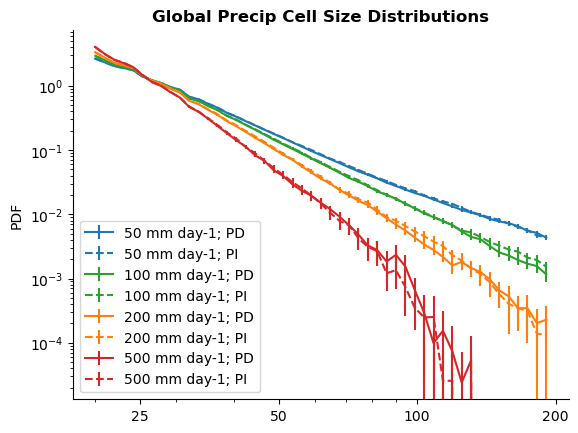

In [16]:
colors = ['C0','C2','C1','C3']
styles = ['-','--']
labs = ['PD', 'PI']

for i in range(4):
    fname = flist[i]
    thresh = str(fname.data).split('_')[4].replace('thresh','')
    
    v = d['PDF_CSD'].mean('day').sel(fname = fname)
    vstd = d['PDF_CSD'].std('day').sel(fname = fname)

    vsem = 2 * vstd / np.sqrt(len(d.day))

    for k, expname in enumerate(v.experiment):
        label = f'{thresh} mm day-1; {labs[k]}' 
        
        y = v.sel(experiment = expname)
        dy = vsem.sel(experiment = expname)
        x = y.diameter*1e-3
        plt.errorbar(x,y, yerr = dy, color = colors[i], linestyle = styles[k], label = label)

sns.despine()
plt.ylabel('PDF')
plt.xscale('log')
plt.yscale('log')
plt.xticks( [25, 50, 100, 200], [25, 50, 100, 200]);

plt.title(f'Global Precip Cell Size Distributions', fontweight = 'bold') 
plt.legend()